# An implementation for JPEG compressing algorithm

Needed imports

In [ ]:
import cv2 as cv
import numpy as np
from queue import PriorityQueue
import heapq
import matplotlib.pyplot as plt
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img1 = cv.imread("/content/drive/MyDrive/Copy of img1.jpg")
img2 = cv.imread("/content/drive/MyDrive/Copy of img2.jpg")

# All steps are implemented in functions:

## A function to resize image to a divisible size by the given number

In [ ]:
def resize_image(img, num=8):
    # Get the original image size
    height, width, _ = img.shape

    # Calculate new dimensions that are divisible by num
    new_height = (height // num) * num
    new_width = (width // num) * num

    # Resize the image using OpenCV's resize function
    resized_img = cv.resize(img, (new_width, new_height))

    return resized_img

## (dividing into / reconstructing from)  blocks

The `divide_image_into_blocks` method takes an image as input and divides it into smaller blocks. Next, it creates an empty list called *blocks* to hold the blocks. It then iterates over each block by using nested for loops. For each block, it calculates the starting and ending indices based on the current block's position and the block size of 8.

In [ ]:
def divide_image_into_blocks(image):
    # Get dimensions of the image
    num_rows, num_cols = image.shape[:2]

    # Calculate number of blocks in each direction
    num_blocks_x = num_cols // 8
    num_blocks_y = num_rows // 8

    # Create empty list to hold blocks
    blocks = []

    # Iterate over each block
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            # Calculate starting and ending indices for this block
            start_x = x * 8
            end_x = start_x + 8

            start_y = y * 8
            end_y = start_y + 8

            # Extract block from image
            block = image[start_y:end_y, start_x:end_x]

            # Add block to list of blocks
            blocks.append(block)

    return blocks

This method reconstructs the image from blocks

In [ ]:
def reconstruct_image_from_blocks(blocks, image_shape):
    # Get dimensions of the image
    num_rows, num_cols = image_shape[:2]

    # Calculate number of blocks in each direction
    num_blocks_x = num_cols // 8
    num_blocks_y = num_rows // 8

    # Create empty array to hold image
    image = np.zeros(image_shape, dtype=np.uint8)

    # Iterate over each block
    block_index = 0
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            # Calculate starting and ending indices for this block
            start_x = x * 8
            end_x = start_x + 8

            start_y = y * 8
            end_y = start_y + 8

            # Extract block from list of blocks
            block = blocks[block_index]
            block_index += 1

            # Insert block into image
            image[start_y:end_y, start_x:end_x] = block

    return image

## Applying DCT on the blocks :

A method which takes list of blocks and computes list of discret cosine transform of each blcok of image

In [ ]:
def apply_dct(blocks):
    dcts = []
    for block in blocks:
        dct = np.stack([cv.dct(np.float32(block[:,:,i])) for i in range(block.shape[2])], axis=2)
        dcts.append(dct)
    return dcts

Inverse of DCT

In [ ]:
def inverse_dct(dct_blocks):
    blocks = []
    for dct_block in dct_blocks:
        block = np.stack([cv.idct(np.float32(dct_block[:,:,i])) for i in range(dct_block.shape[2])], axis=2)
        blocks.append(block)
    return blocks

## Applying Frequency quantization on DCT coefficients (we can set how lossie the quantization to be)


The `quantize` function takes a list of blocks and an optional parameter `lossie` as input. It creates a quantization table based on the `lossie` value.

In [ ]:
def quantize(blocks, lossie=1):
    quantization_table = lossie * np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])
    quantized = []
    for block in blocks:
        dct_quantized = np.stack([np.round(block[:,:,i] / quantization_table) for i in range(block.shape[2])], axis=2)
        quantized.append(dct_quantized)
    return quantized, quantization_table

In [ ]:
def dequantize(quantized_blocks, quantization_table):
    blocks = []
    for quantized_block in quantized_blocks:
        dct_dequantized = np.stack([np.round(quantized_block[:,:,i] * quantization_table) for i in range(quantized_block.shape[2])], axis=2)
        blocks.append(dct_dequantized)
    return blocks

## Zigzag scan


The `zigzag_scan` method takes a list of blocks as input and applies a zigzag order pattern to the Y, Cb, and Cr channels of each block. It creates an ordered list of blocks by flattening the channels and rearranging them according to the zigzag order. The ordered_blocks are then stacked together and added to a new list called `ordered_blocks`. Finally, the method returns the `ordered_blocks` list, which contains the blocks with the zigzag scan applied. This method is commonly used in image and video compression algorithms to optimize the encoding of the image data

In [ ]:
def zigzag_scan(blocks):
    zigzag_order = np.array([
    [ 0,  1,  5,  6, 14, 15, 27, 28],
    [ 2,  4,  7, 13, 16, 26, 29, 42],
    [ 3,  8, 12, 17, 25, 30, 41, 43],
    [ 9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]])

    ordered_blocks = []
    flatten_orders = zigzag_order.flatten()
    for block in blocks:
        y, cb, cr = block[:,:,0].flatten(), block[:,:,1].flatten(), block[:,:,2].flatten()
        y_ordered = y[flatten_orders]
        cb_ordered = cb[flatten_orders]
        cr_ordered = cr[flatten_orders]
        ordered_blocks.append(np.stack([y_ordered,cb_ordered, cr_ordered,], axis=1))
    return ordered_blocks

inverse of quantization

In [ ]:
def inverse_zigzag_scan(ordered_blocks):
    zigzag_order = np.array([
        [ 0,  1,  5,  6, 14, 15, 27, 28],
        [ 2,  4,  7, 13, 16, 26, 29, 42],
        [ 3,  8, 12, 17, 25, 30, 41, 43],
        [ 9, 11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63]])

    blocks = []
    flatten_orders = zigzag_order.flatten()
    for ordered_block in ordered_blocks:
        y_ordered, cb_ordered, cr_ordered = ordered_block[:,0], ordered_block[:,1], ordered_block[:,2]
        y = np.zeros((64,))
        cb = np.zeros((64,))
        cr = np.zeros((64,))
        y[flatten_orders] = y_ordered
        cb[flatten_orders] = cb_ordered
        cr[flatten_orders] = cr_ordered
        y = np.reshape(y, (8, 8))
        cb = np.reshape(cb, (8, 8))
        cr = np.reshape(cr, (8, 8))
        block = np.stack([y, cb, cr], axis=2)
        blocks.append(block)
    return blocks

## Coding and decodeing the coefficients

The `huffman_encode` method takes an array as input and performs Huffman encoding on it. The `huffman_decode` performs the decoding.

In [ ]:
import heapq
from collections import defaultdict

def huffman_encode(arr):
    # Count the frequency of each integer in the array.
    freq = defaultdict(int)
    for num in arr:
        freq[num] += 1

    # Build a Huffman tree from the frequencies.
    heap = [[wt, [sym, ""]] for sym, wt in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Generate the Huffman codes for each integer.
    huffman_codes = dict(heapq.heappop(heap)[1:])

    # Encode the array using the Huffman codes.
    encoded_arr = ""
    for num in arr:
        encoded_arr += huffman_codes[num]

    return encoded_arr, huffman_codes

def huffman_decode(encoded_arr, huffman_codes):
    # Invert the Huffman codes dictionary.
    inv_huffman_codes = {v: k for k, v in huffman_codes.items()}
    if encoded_arr == "":
        return np.zeros(64)
    # Decode the array using the inverted Huffman codes.
    decoded_arr = []
    code = ""
    for bit in encoded_arr:
        code += bit
        if code in inv_huffman_codes:
            decoded_arr.append(inv_huffman_codes[code])
            code = ""

    return np.array(decoded_arr)


This method, encodes each channel separately





In [ ]:
def huffman_encode_matrix(matrix):
    # Initialize list to store encoded data for each channel
    encoded_channels = []
    code_dicts = []
    # Loop through each channel in the matrix
    for i in range(matrix.shape[1]):
        # Extract the channel as a 1D array
        arr = matrix[:,i]

        # Encode the input data using Huffman coding
        encoded_arr, code_dict = huffman_encode(arr)

        # Append the encoded data and code dictionary to the list of encoded channels
        encoded_channels.append(encoded_arr)
        code_dicts.append(code_dict)

    return encoded_channels, code_dicts

def huffman_decode_matrix(encoded_channels, code_dicts):
    # Initialize matrix to store decoded data
    decoded_matrix = np.zeros((64, len(encoded_channels)), dtype=np.uint8)

    # Loop through each channel in the encoded data
    for i in range(len(encoded_channels)):
        # Decode the encoded data using the generated code dictionary
        decoded_arr = huffman_decode(encoded_channels[i], code_dicts[i])

        # Set the decoded channel in the matrix
        decoded_matrix[:,i] = decoded_arr

    return decoded_matrix

Encoder of all blocks together

In [ ]:
def encode(blocks):
    list_encode_channels, list_code_dicts = [],[]
    for block in blocks :
        encoded_channels, code_dict = huffman_encode_matrix(block)
        list_encode_channels.append(encoded_channels)
        list_code_dicts.append(code_dict)
    return list_encode_channels, list_code_dicts

def decode(list_encode_channels, list_code_dict):
    decoded_blocks = []

    for encoded_channels, code_dict in zip(list_encode_channels, list_code_dict):

        block = huffman_decode_matrix(encoded_channels, code_dict)
        decoded_blocks.append(block)

    return decoded_blocks


# Running the steps of comopression on the images

Converting the color space from BGR to YCbCr :

In [ ]:
img1_ycbcr = cv.cvtColor(img1, cv.COLOR_BGR2YCrCb)
img2_ycbcr = cv.cvtColor(img2, cv.COLOR_BGR2YCrCb)

Normalizing the images

In [ ]:
normal_img1 = img1_ycbcr - (127,127,127)
normal_img2 = img2_ycbcr - (127,127,127)

dividing into blocks

In [ ]:
img1_blocks = divide_image_into_blocks(normal_img1)
img2_blocks = divide_image_into_blocks(normal_img2)

aplying DCT

In [ ]:
img1_dcts = apply_dct(img1_blocks)
img2_dcts = apply_dct(img2_blocks)

quantization

In [ ]:
img1_qu, quantization_table = quantize(img1_dcts)
img2_qu, quantization_table = quantize(img2_dcts)

zigzag scannning

In [ ]:
img1_zig = zigzag_scan(img1_dcts)
img2_zig = zigzag_scan(img2_dcts)

encoding

In [ ]:
encode_channels_1, code_dict1 = encode(img1_zig)
encode_channels_2, code_dict2  = encode(img2_zig)

checking the size of compressed images and computing compression ratio

In [ ]:
compressed_size_img1 = sys.getsizeof(encode_channels_1) + sys.getsizeof(code_dict1)
compressed_size_img2 = sys.getsizeof(encode_channels_2) + sys.getsizeof(code_dict2)
img1_size = sys.getsizeof(img1)
img2_size = sys.getsizeof(img2)

In [ ]:
img1_compression_ratio = img1_size/compressed_size_img1
img2_compression_ratio = img2_size/compressed_size_img2
img1_redundancy_ratio = 1 - 1/(img1_compression_ratio)
img2_redundancy_ratio = 1 - 1/(img2_compression_ratio)

In [ ]:
print(f"Compression ratio of the first image using this approach is : {img1_compression_ratio} and its data redundancy is about {100* img1_redundancy_ratio} ")
print(f"Compression ratio of the second image using this approach is : {img2_compression_ratio} and its data redundancy is about {100* img2_redundancy_ratio} ")

Compression ratio of the first image using this approach is : 11.509577330524762 and its data redundancy is about 91.31158363784671 
Compression ratio of the second image using this approach is : 10.736116156217243 and its data redundancy is about 90.68564473922068 


# Decompressing the images

decoding huffman form of blocks

In [ ]:
decoded1 = decode(encode_channels_1, code_dict1)
decoded2 = decode(encode_channels_2, code_dict2)

inverse the zigzag path and getting back each quantized blocks

In [ ]:
img1_inv_zig = inverse_zigzag_scan(decoded1)
img2_inv_zig = inverse_zigzag_scan(decoded2)

inverse the quantization to get back the DCT form of blocks

In [ ]:
img1_dq = dequantize(img1_inv_zig, quantization_table)
img2_dq = dequantize(img2_inv_zig, quantization_table)

inverse DCT and haveing the image in spatial domain

In [ ]:
img1_idct = inverse_dct(img1_dq)
img2_idct = inverse_dct(img2_dq)

Now just reconstruct the image and then getting back image from its 64 blocks

In [ ]:
img1_ = reconstruct_image_from_blocks(img1_idct, img1.shape)
img2_ = reconstruct_image_from_blocks(img2_idct, img2.shape)

/var/folders/9y/vw5physn1xj4wpb41wh0q6gh0000gn/T/ipykernel_5060/1750821587.py:28: RuntimeWarning: invalid value encountered in cast
  image[start_y:end_y, start_x:end_x] = block


shift intensities to where they were

In [ ]:
img1_r_ycrcb = img1_ + (127,127,127)
img2_r_ycrcb = img2_ + (127,127,127)

In [ ]:
img1_r_ycrcb = img1_r_ycrcb.astype(np.uint8)
img2_r_ycrcb = img2_r_ycrcb.astype(np.uint8)

Convert the image form YCrCb back to RGB

In [ ]:
img1_r = cv.cvtColor(img1_r_ycrcb, cv.COLOR_YCrCb2RGB)
img2_r = cv.cvtColor(img2_r_ycrcb, cv.COLOR_YCrCb2RGB)

As we can see this is the result of converting the image back to what it was and ther is not that much of chang in the original images

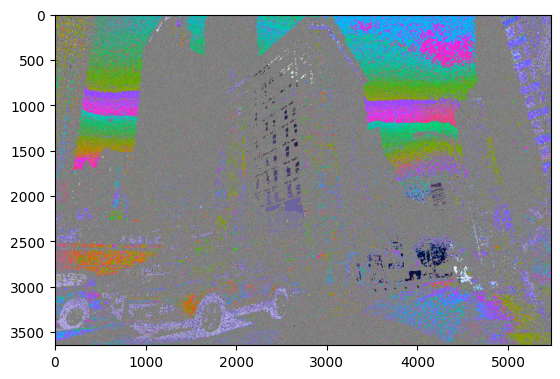

In [ ]:
plt.imshow(img1_r)
plt.show()

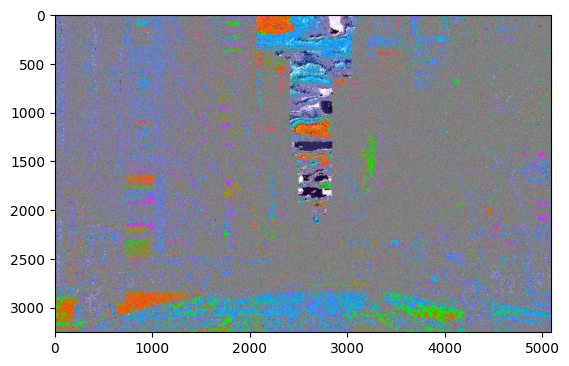

In [ ]:
plt.imshow(img2_r)